# The Peaklet Transform
The purpose of the Peaklet Transform is to interpret a nonnegative time series $f(t)$, such as a light curve, as a superposition of pulses with particular durations. I have chosen the name peaklet to evoke wavelets, because this is a multiscale transform. The wavelet transform uses a mother wavelet function, arbitrarily scaled and translated, to form an overcomplete basis. So, if the mother wavelet function is $\mu$, the time series is represented thus:
$$
    f(t) = \sum_{x,s} w_{x,s} \mu\left[ (t-x)/s \right].
$$
The peaklet transform similarly begins with a scalable function, $\varpi\left[(t+x)/s\right]$, where $s$ is the scale. In the peaklet transform, however, the time series is _not_ represented as a superposition. Instead, scales are filtered from $f(t)$ one at a time, beginning from the largest scale, as follows:
1. Define a range of scales, $s_i = 2^{i/\delta} s_1$, $i=0, i,... N$, where $s_1$ is the next-to-smallest scale, $\delta$ determines the logarithmic spacing, and $N$ is chosen so that $s_N$ is shorter than the time series.
1. Initialize the residual function, $\rho(t):=f(t)$, and $i:=N$.
1. For scale $s_i$, at each time $t$, find the optimal lag $x_it$ as follows:
$$
    x_t = \arg\min_x \frac{f(t+x)}{\varpi(x/s_i)}
$$
1. The peaklet transform at scale $i$ and time $t$ is then __(IS THIS CORRECT?)__
$$
    \tau_i(t) =  \max_z \left[ \varpi\left( (t-z)/s_i\right) \frac{f(t+x_z)}{\varpi(x_z/s_i)} \right].
$$
1. The residual is now $\rho(t) := \rho(t) - \tau_{i}(t)$. Conceptually, this corresponds 
1. If $i>1$, decrement $i$ and return to step 3.
1. The smallest scale, $s_0$, takes up what's left: $\tau_0(t) = \rho(t) $. 

## Inverse
The inverse peaklet transform is simply
$$
    f(t) = \sum_i \tau_i(t).
$$



_The remainder of this notebook provides some demonstrations of the discrete Peaklet Transform._

## A simple dataset

In [1]:
import numpy as np
import time

Nt = 1024 # number of elements in data array

<IPython.core.display.Javascript object>


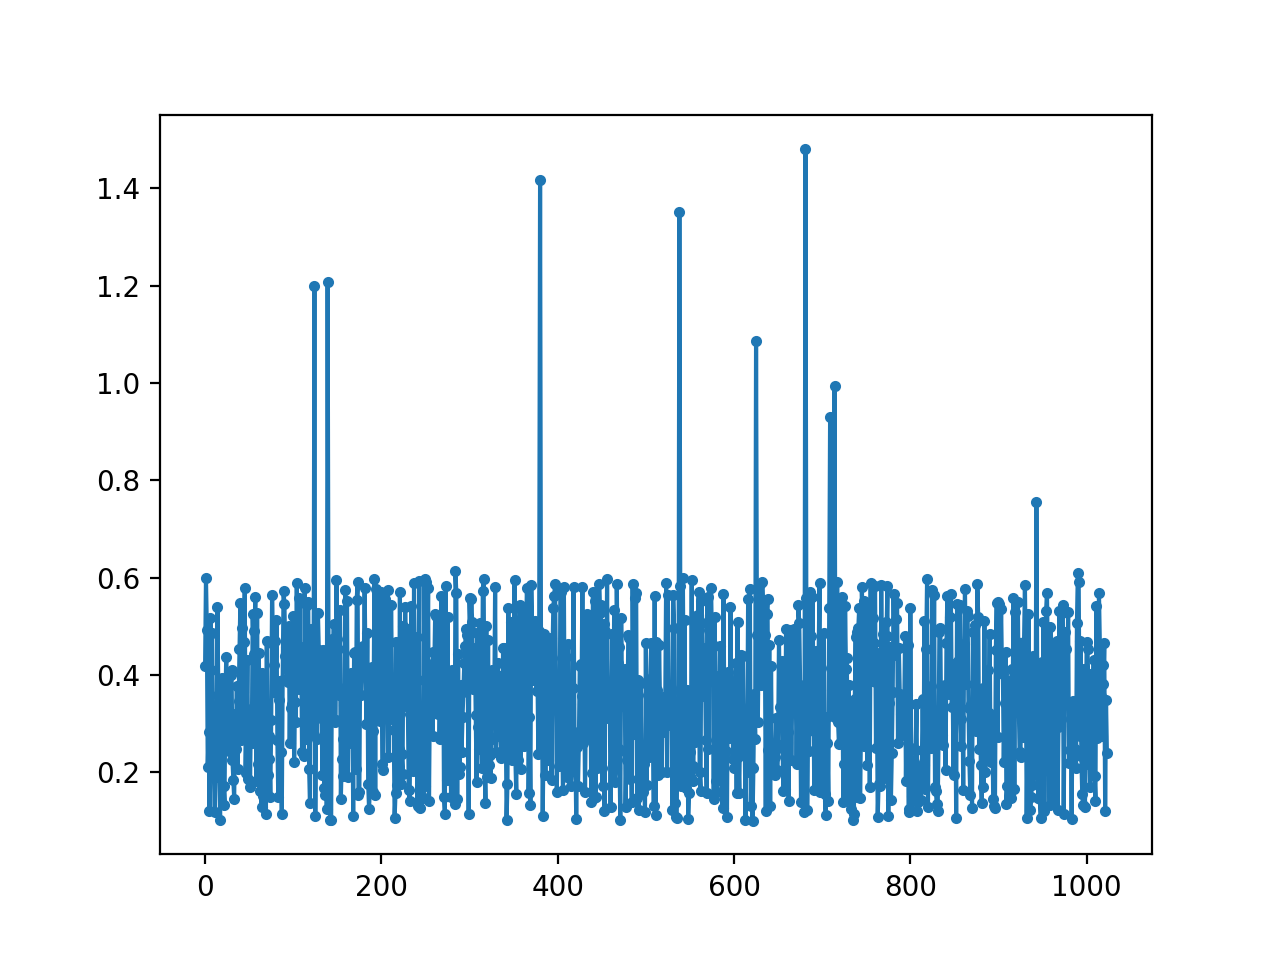

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

# fake data
signal1 = np.random.rand(Nt)**200
#for i in range(8):
#    signal1 += 0.5*(np.roll(signal1, 1) + np.roll(signal1, -1))
signal1 += 0.1 + 0.5*np.random.rand(Nt)  # add some noisy background.
plt.figure()
plt.plot(signal1,'.-');

In [3]:
# Timing test
import peaklets as peaklet

start = time.perf_counter()
peaklet.pkxform(signal1)
end = time.perf_counter()
print("Compilation and execution: ",end-start,' s.')

start = time.perf_counter()
pk = peaklet.pkxform(signal1)
end = time.perf_counter()
print("Execution only: ",end-start,' s.')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Compilation and execution:  11.276567960972898  s.
Execution only:  0.02355732989963144  s.


<IPython.core.display.Javascript object>


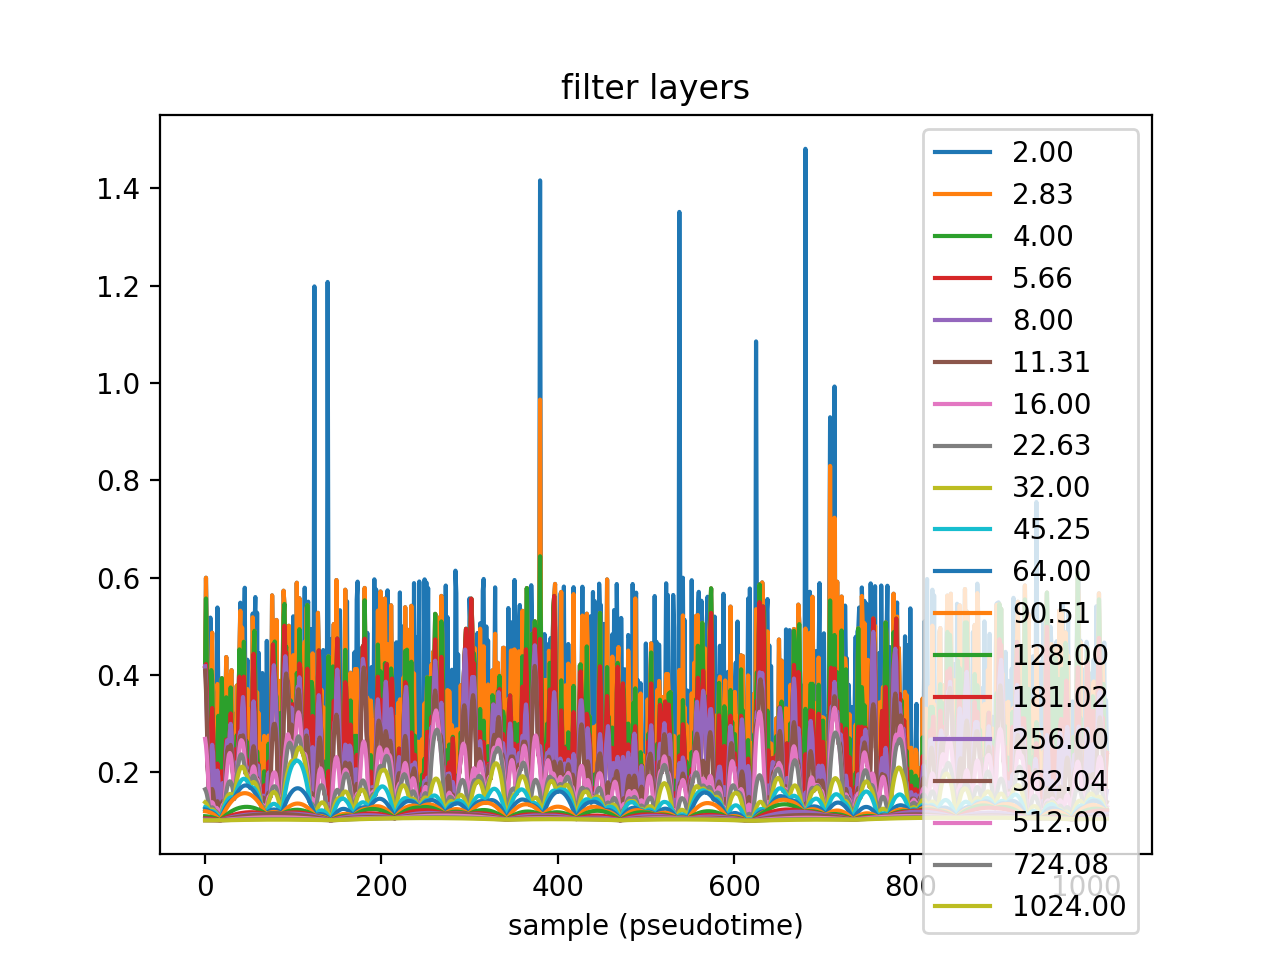

In [4]:
# Plot the filter layers.
Nsc = len(pk.scales)
plt.figure()
plt.title('filter layers')
for i in range(Nsc):
    labeltext = "{:.2f}"
    plt.plot(pk.filters[i,:],label=labeltext.format(pk.scales[i]))
plt.xlabel('sample (pseudotime)')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


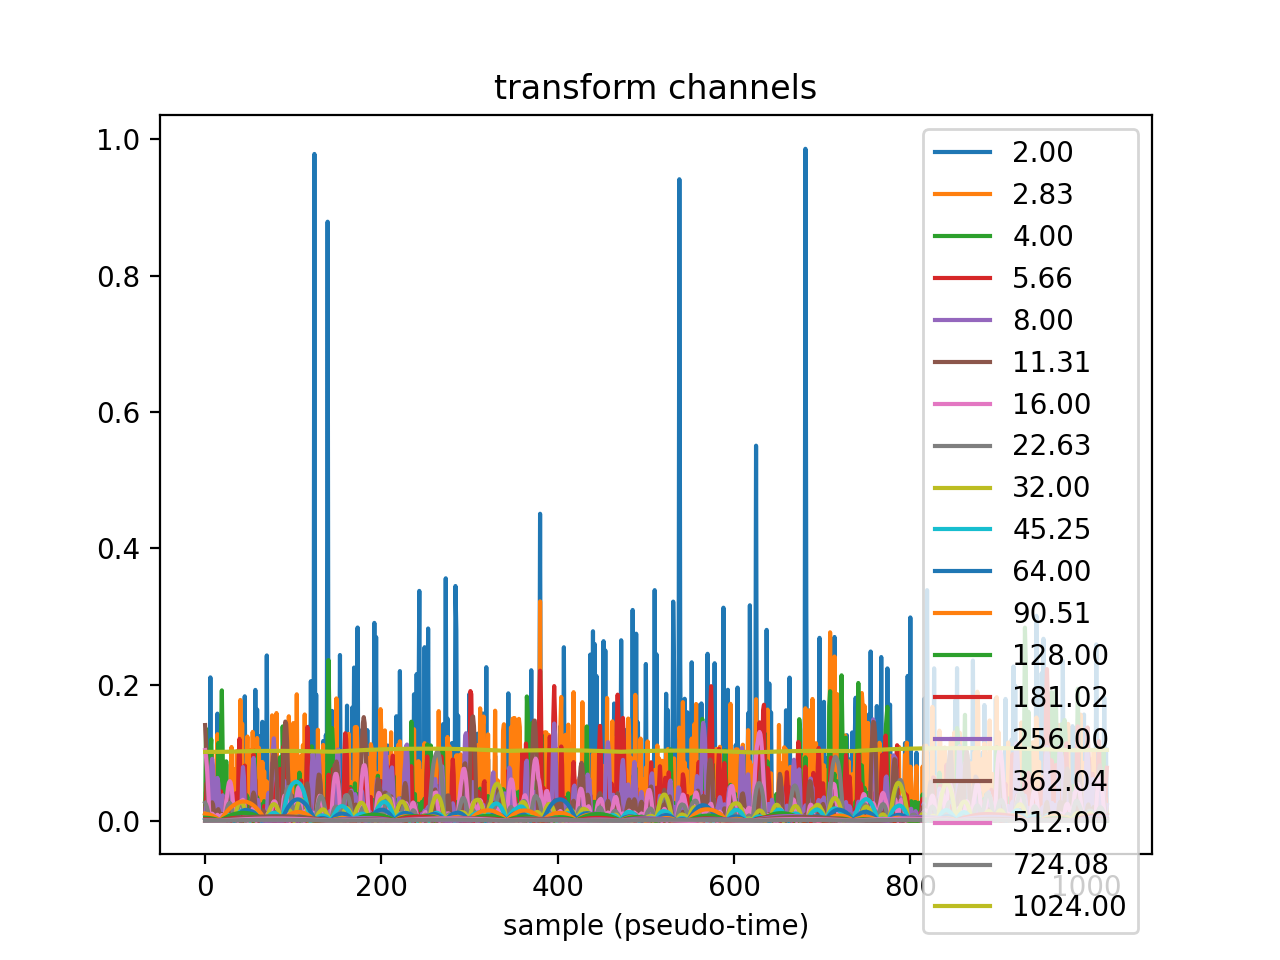

0.0


In [5]:
# plot the transform.
(Ntr,Nt) = pk.xform.shape
plt.figure()
plt.title('transform channels')
for i in range(Ntr):
    labeltext = "{:.2f}"
    plt.plot(pk.xform[i,:],label=labeltext.format(pk.scales[i]))
plt.xlabel('sample (pseudo-time)')
plt.legend()
plt.show()
print(np.amin(pk.xform))

In [6]:
def psplot(pkobj,dt=1.0,tunit='samples',punit='counts'):
    """
    Calculate and plot multiscale power spectrum.
    
    pkobj = PeakletXform object
    dt = sample period (default 1)
    tunit = unit of the time (sampling) axis (default 'samples')
    punit = unit of the light curve (default 'counts')
    """
    timescales = pkobj.scales*dt
    ps = np.sum(pkobj.xform,1)
    plt.semilogx(timescales, ps, '-o')
    plt.xlabel('scale ('+tunit+')')
    plt.ylabel('power ('+punit+')')
    return ps, timescales

<IPython.core.display.Javascript object>


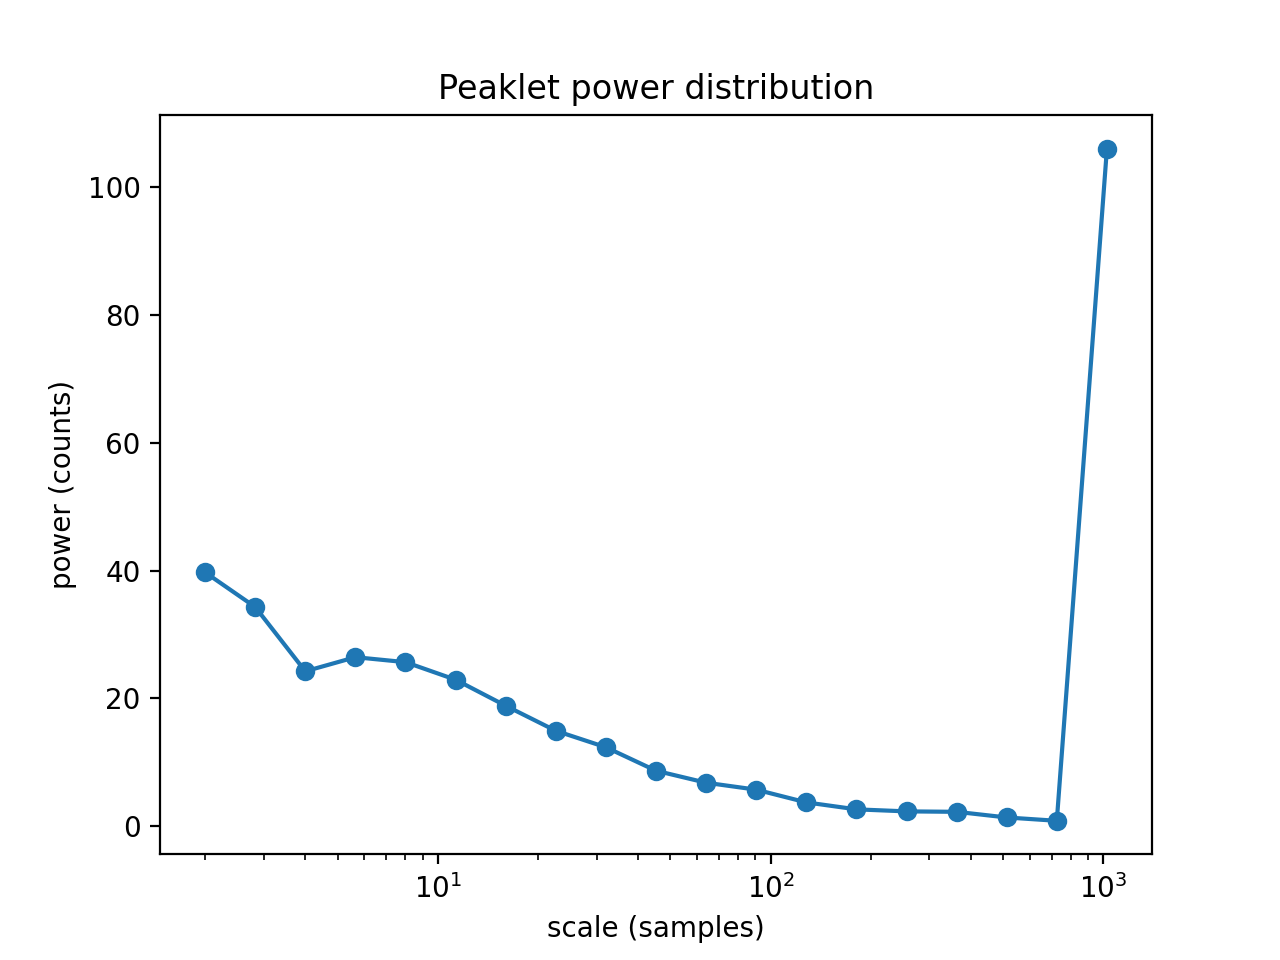

In [7]:
plt.figure()
ps,_ = psplot(pk)
plt.title('Peaklet power distribution');

<IPython.core.display.Javascript object>


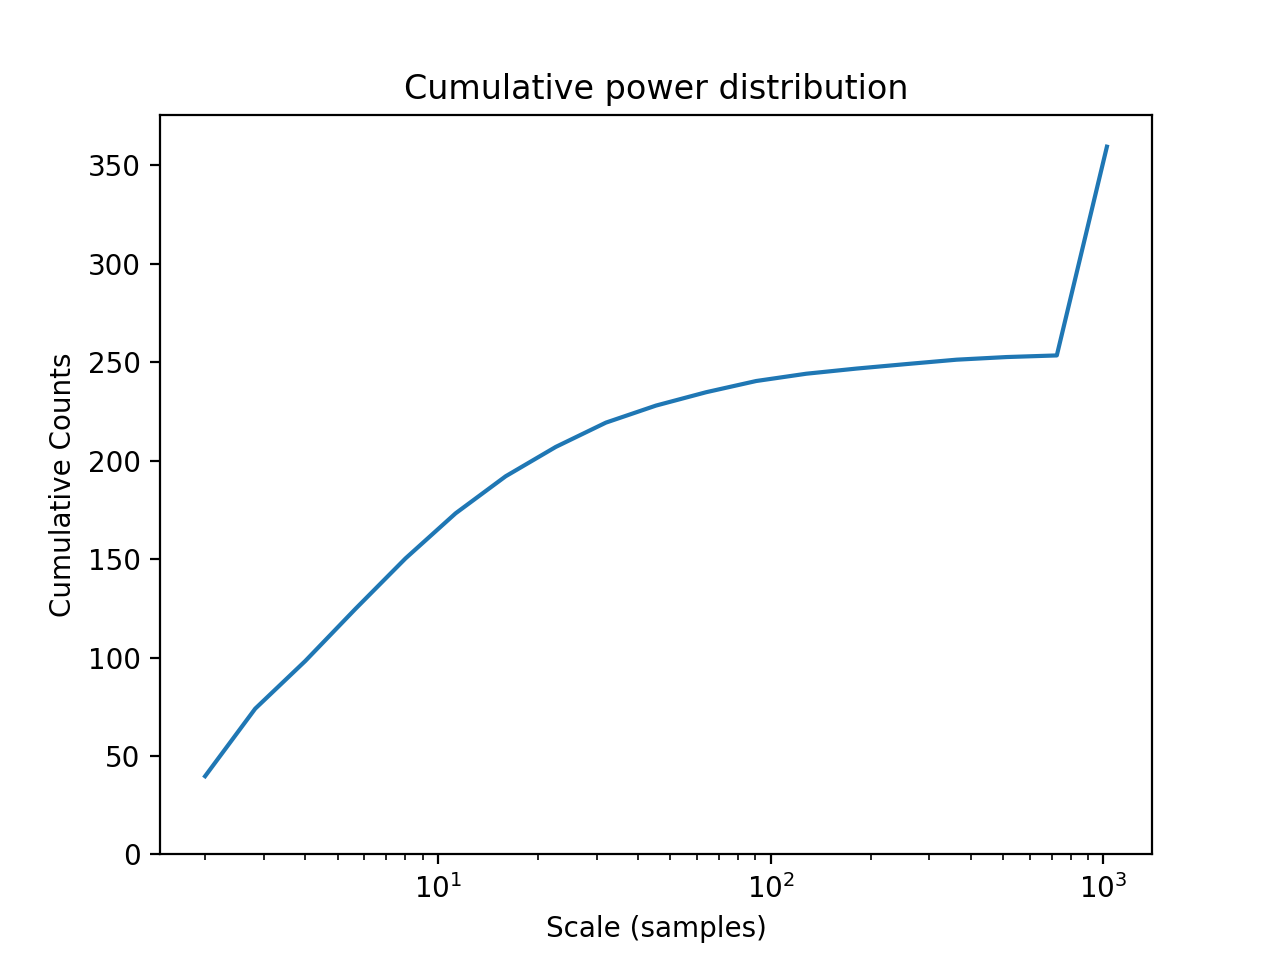

In [8]:
ps_cum = np.cumsum(ps)

plt.figure()
plt.semilogx(pk.scales,ps_cum)
plt.ylim(bottom=0)
plt.title('Cumulative power distribution')
plt.xlabel('Scale (samples)')
plt.ylabel('Cumulative Counts');

<IPython.core.display.Javascript object>


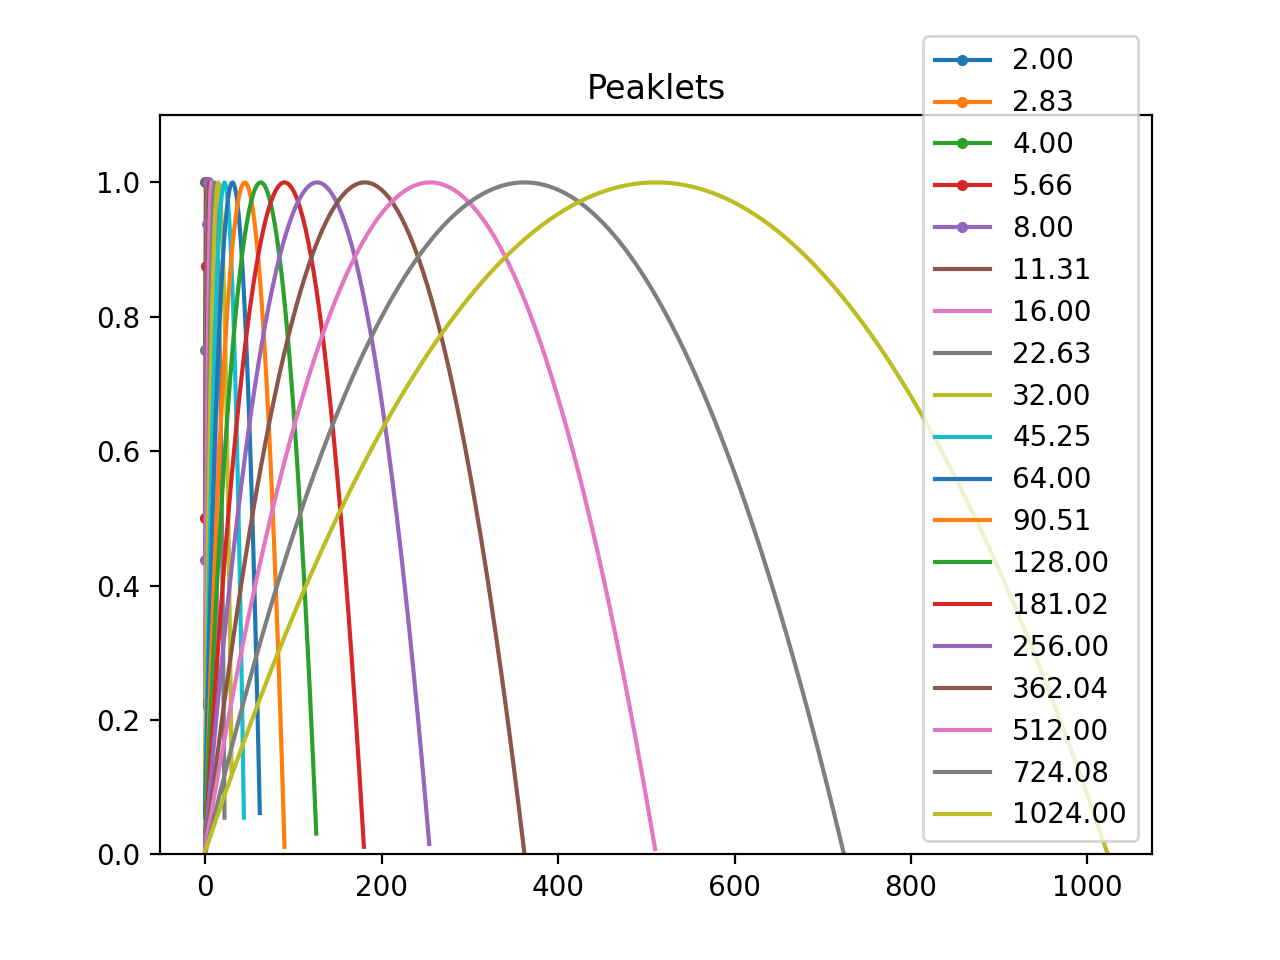

In [9]:
# Plot all the peaklets

plt.figure()
for i in range(Nsc):
    sc = pk.scales[i]
    if sc<10:
        marker='.-'
    else:
        marker='-'
    plt.plot(pk.pklets[i],marker,label=labeltext.format(sc))
plt.title('Peaklets');
plt.ylim((0,1.1))
plt.legend();

## Approximate Linearity
The peaklet transform, $\mathcal{P}$, is a mapping from nonnegative real time series $f(t)$ to a vector array of time series, $\mathbf{F}(t)$. I conjecture that $\mathcal{P}$, under certain assumptions, is _approximately linear_. I describe this property$^1$ as follows:

1. For any signal $f(t)$, and real constant $a \ge 0$,
$$
    \mathcal{P}(af) = a\mathcal{P}(f).
$$
1. If signals $f(t)$ and $g(t)$ are each composed of peaks with no mutual overlap in time, then
$$
    \mathcal{P}(f+g) = \mathcal{P}(f) + \mathcal{P}(g).
$$
1. If $f(t)$ and $g(t)$ are each composed of peaks with very different scales, then
$$
    \mathcal{P}(f+g) \approx \mathcal{P}(f) + \mathcal{P}(g).
$$



The following properties of $\mathcal{P}$ help to round out the picture.

4. There exists an inverse transform, $\mathcal{P}^{-1}$, with the property
$$ \mathcal{P}^{-1}\left( \mathcal{P}(f) \right) = f. $$
1. However, $\mathcal{P}$ is _not_ the inverse of $\mathcal{P}^{-1}$. That is, for some object $\tau$ in transform space, the following may or may not be an equality:
$$
    \mathcal{P} \left( \mathcal{P}^{-1}(\mathbf{T}) \right) \stackrel{?}{=} \mathbf{T}
$$
__Comment:__ Unless there exists an $f$ such that $\mathbf{T} = \mathcal{P}(f)$, the above relation is an inequality. _The transform space is much bigger than signal space_, and so $\mathcal{P}$ maps onto a proper subset, $\mathcal{F}$, of transform space. Most of the elements of transform space will never be generated using $\mathcal{P}$.
1. The inverse transform is linear. That is, given two signals $f(t)$ and $g(t)$,
$$
    \mathcal{P}^{-1}\left( \mathcal{P}(f) + \mathcal{P}(g)\right) = f + g.
$$
__Comment:__ In view of the previous rule, we cannot just hit both sides of the above equation with $\mathcal{P}$ to prove linearity! In this regard, please note that $\mathcal{F}$ is not closed under addition.


$^1$I thought about using the term [_quasilinear_, but this term is already taken.](https://www.cambridge.org/core/journals/bulletin-of-the-australian-mathematical-society/article/quasilinearity-of-some-composite-functionals-with-applications/31B0B0C9035DD3C652730F850A2A3A12) So are semi- and demilinear.

### Numerical tests of approximate linearity
Let's investigate quantitatively what the $\approx$ means in property (3) above. What I've been calling, e.g., $f(t)$, are really discretely sampled time series, which might be better denoted $f_t$, where $t$ is an integer time index. The transform space elements are rank two tensors, e.g.
$$
    f_t \stackrel{\mathcal{P}}{\longrightarrow} F_{ts}.
$$
Note that all elements of the time series $f_t$ and of the rank two tensor $F_{ts}$ are strictly _nonnegative_.
In addition to the time index, $F_{ts}$ is indexed by the scale, $s$, which is again dimensionless (like $t$, it has units of the sample time), but indicates a pulse width along the time axis. The inverse operator, $\mathcal{P}^{-1}$, is a very simple linear operation:
$$
    f_t = \mathcal{P}^{-1} F = \sum_s F_{ts}.
$$
Despite this, $\mathcal{P}$ is at best _approximately_ linear, and sometimes highly nonlinear. The linearity (nonlinearity) may be described as the degree of (in)accuracy in the following relation:
$$
    \mathcal{P}(f+g) \approx \mathcal{P}(f) + \mathcal{P}(g).
$$
I can measure the degree of inequality between two members of transform space, $F$ and $G$, using a normalized $L^1$ norm of their difference:
$$
    \Delta_{1N} (F,G) \equiv \frac{ \lVert F-G \rVert_1 }{\lVert F \rVert_1 + \lVert G \rVert_1} 
        = \frac{ \sum_{t,s} \left| F_{ts} - G_{ts} \right| }{ 
        \sum_{t,s} \left( F_{ts} + G_{ts} \right) }.
$$
I have taken advantage of the nonnegativity of both $F$ and $G$. Note that 
$$
    0 \le \Delta_{1N} (F,G) \le 1.
$$
If $\Delta_{1N} (F,G)=0$, then $F=G$. If $\Delta_{1N} (F,G)=1$, then there is no overlap between $F$ and $G$. That is, there is no $t,s$ such that both $F_{ts}$ and $G_{ts}$ are nonzero.

To quantify the degree of nonlinearity in $\mathcal{P}$ with respect to $F=\mathcal{P}(f)$ and $G=\mathcal{P}(g)$, we may simply use $\Delta_{1N} \left(F+G,\mathcal{P}(f+g) \right)$.



In [10]:
def Delta1N(F,G): 
    return np.sum(np.abs(F-G))/np.sum(F+G)

<IPython.core.display.Javascript object>


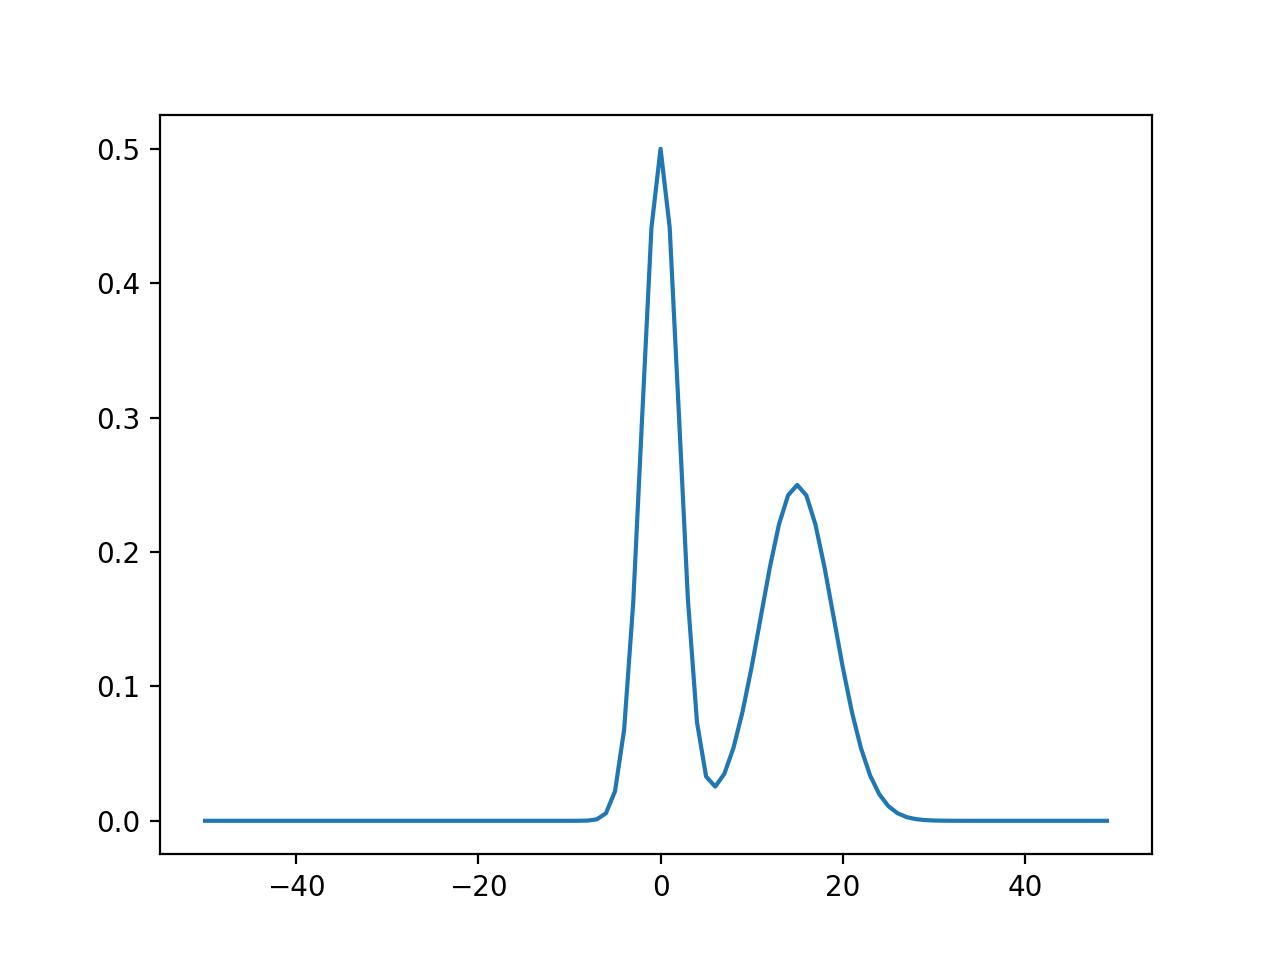

0.8635061121873018
5.013256549262001 5.013256549262001


In [11]:
Nt = 100
t = np.arange(Nt)-Nt/2.
wf = 2 # width of f
wg = 4 # width of g
f = (1/wf)*np.exp(-t**2/(2*wf**2))
shift = 2.5*(wf+wg)
g = (1/wg)*np.exp(-(t-shift)**2/(2*wg**2))
plt.figure()
plt.plot(t,f+g,'-')

fx = peaklet.pkxform(f)
gx = peaklet.pkxform(g)
fgx = peaklet.pkxform(f+g)

print(1-Delta1N(fgx.xform,gx.xform+fx.xform))
print(np.sum(fgx.xform), np.sum(gx.xform+fx.xform))

<IPython.core.display.Javascript object>


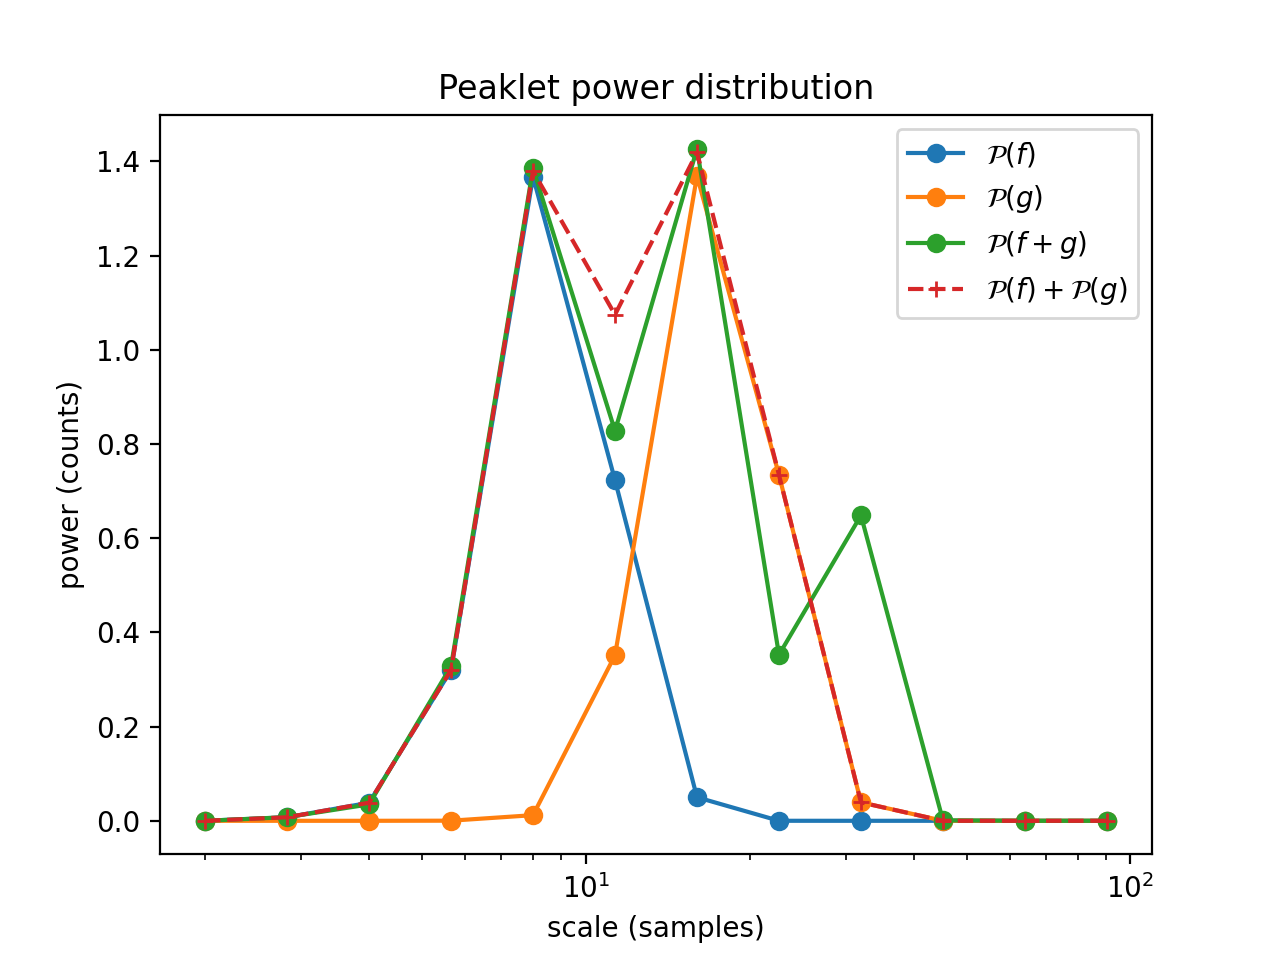

In [12]:
plt.figure()
ps = psplot(fx)
ps = psplot(gx)
ps = psplot(fgx)
plt.plot(fx.scales, np.sum(fx.xform+gx.xform,1),'+--')

plt.legend([r'$\mathcal{P}(f)$',r'$\mathcal{P}(g)$',r'$\mathcal{P}(f+g)$','$\mathcal{P}(f)+\mathcal{P}(g)$'])
plt.title('Peaklet power distribution');

In [13]:
######## LINEARITY CONTOUR PLOT ##########


Nt = 1000
t = np.arange(Nt) - Nt/2.
wf = 2**np.linspace(-2,8,num=200) # width of f
wg = 8                            # width of g
nshift = np.linspace(-5, 5, num=200)

wfarr, nsarr, tarr = np.meshgrid(wf,nshift,t)

f = (1/wfarr)*np.exp( -tarr**2 / (2*wfarr**2) )

g = (1/wg)*np.exp( -(tarr - nsarr*(wfarr+wg))**2 / (2*wg**2) )


In [14]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [15]:
t_0 = time.perf_counter()
fx = peaklet.pkxform(f)
t_f = time.perf_counter()
print('transformed f array, ',f.shape, ', in ',t_f-t_0,'s.')
gx = peaklet.pkxform(g)
t_g = time.perf_counter()
print('transformed g array, ',g.shape, ', in ',t_g-t_f,'s.')
fgx = peaklet.pkxform(f+g)
t_fg = time.perf_counter()
print('transformed f+g array in ',t_fg-t_g,'s.')
print('transform shape is ', fx.xform.shape)

transformed f array,  (200, 200, 1000) , in  164.38065037003253 s.
transformed g array,  (200, 200, 1000) , in  170.91292066092137 s.
transformed f+g array in  233.07402330602054 s.
transform shape is  (18, 200, 200, 1000)


<IPython.core.display.Javascript object>


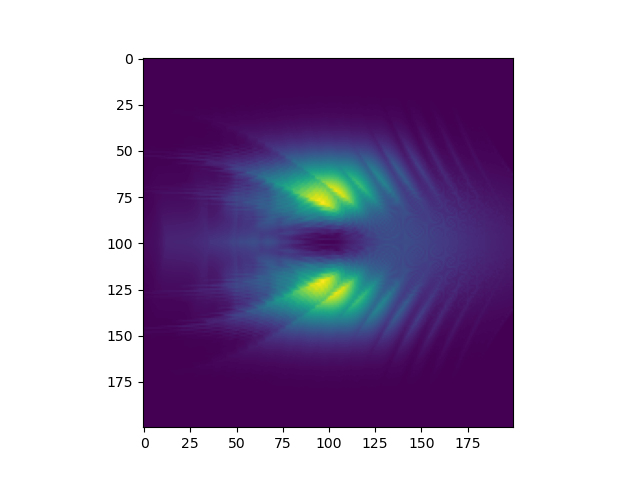

In [16]:
nonlinearity = np.sum(np.abs(fx.xform+gx.xform-fgx.xform),axis=(0,-1))/np.sum(fx.xform+gx.xform+fgx.xform,axis=(0,-1))
plt.figure()
plt.imshow(nonlinearity)


<IPython.core.display.Javascript object>


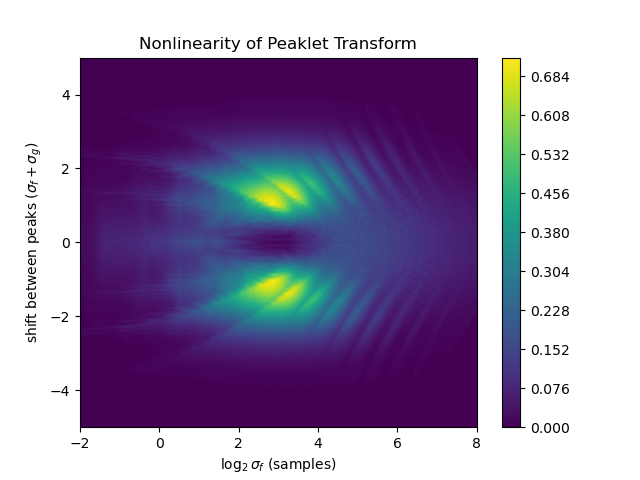

In [17]:
plt.figure()
plt.contourf(np.log2(wf),nshift,nonlinearity, levels=200)
plt.colorbar()
plt.title('Nonlinearity of Peaklet Transform')
plt.xlabel(r'$\log_2 \sigma_f$ (samples)')
plt.ylabel(r'shift between peaks ($\sigma_f+\sigma_g$)')
plt.show()